# First Test of Comapring New Method to Actual SHAP Values

## Setup

In [1]:
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from siuba import _, select

## Data

In [11]:
# Set the Seed
np.random.seed(25)

# Get the Predictors
x1 = np.random.uniform(low = 0, high = 1, size = 10000)
x2 = np.random.uniform(low = 0, high = 1, size = 10000)
d = {"x1":x1, "x2":x2}
X = pd.DataFrame(data = d)

# Get the three different responses
y1 = x1 + x2
y2 = 2 * x1 + 2 * x2
y3 = (x1 + x2) * (2 * x1 + 2 * x2)

# Make the data for the 3 models
d1 = xgb.DMatrix(X, label=y1)
d2 = xgb.DMatrix(X, label=y2)
d3 = xgb.DMatrix(X, label=y3)

X.head()

,x1,x2
0,0.870124,0.219242
1,0.582277,0.648587
2,0.278839,0.288863
3,0.185911,0.313272
4,0.411100,0.561066


## Models

In [12]:
param = {'max_depth': 5, 'eta': 0.3, 'objective': 'reg:squarederror', "eval_metric":"mae", "alpha":0.1, "gamma":0.1}

bst1 = xgb.train(param, d1, 10)
bst2 = xgb.train(param, d2, 10)
bst3 = xgb.train(param, d3, 10)

## SHAP Values

In [38]:
shap1_ex = shap.TreeExplainer(bst1)
shap1 = shap1_ex.shap_values(X)
shap2_ex = shap.TreeExplainer(bst2)
shap2 = shap2_ex.shap_values(X)
shap3_ex = shap.TreeExplainer(bst3)
shap3 = shap3_ex.shap_values(X)

### SHAP Visualizations for the 3 Models

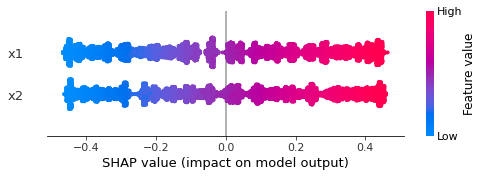

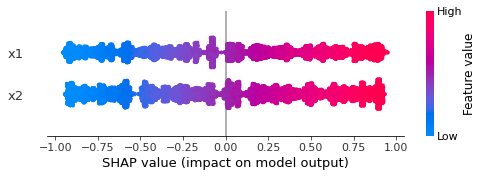

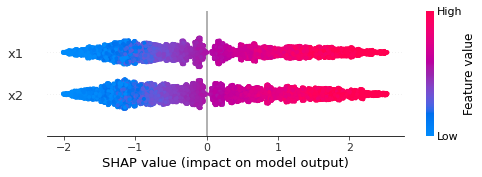

In [14]:
shap.initjs()

shap.summary_plot(shap1, X)
shap.summary_plot(shap2, X)
shap.summary_plot(shap3, X)

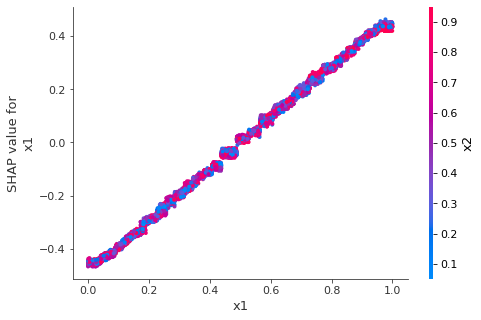

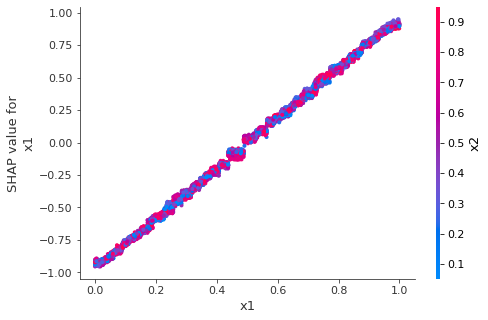

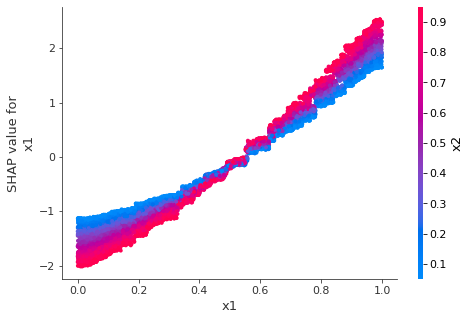

In [15]:
shap.dependence_plot("x1", shap1, X)
shap.dependence_plot("x1", shap2, X)
shap.dependence_plot("x1", shap3, X)

### New Multiplicative Method

In [17]:
print(np.shape(shap1))
print(np.shape(shap2))
np.shape(shap1)[1]

(10000, 2)
(10000, 2)


2

In [25]:
shap1[:,0]

array([ 0.3476479 ,  0.0685757 , -0.21134458, ..., -0.37291273,
        0.35741574,  0.13602614], dtype=float32)

In [28]:
shap2[:,0]

array([ 0.6997788 ,  0.13685663, -0.4191981 , ..., -0.7436966 ,
        0.7099125 ,  0.25650245], dtype=float32)

In [27]:
shap1[:,0] * shap2[:,0]

array([0.24327663, 0.00938504, 0.08859525, ..., 0.27733392, 0.2537339 ,
       0.03489104], dtype=float32)

In [21]:
np.arange(0,2)

array([0, 1])

In [41]:
multi_shap1 = (shap1[:,0] * shap2[:,0] + shap1[:,0] * shap2[:,1] + shap1[:,0] * shap2_ex.expected_value + 
               shap2[:,0] * shap1[:,0] + shap2[:,0] * shap1[:,1] + shap2[:,0] * shap1_ex.expected_value) / 2
multi_shap2 = (shap1[:,1] * shap2[:,0] + shap1[:,1] * shap2[:,1] + shap1[:,1] * shap2_ex.expected_value + 
               shap2[:,1] * shap1[:,0] + shap2[:,1] * shap1[:,1] + shap2[:,1] * shap1_ex.expected_value) / 2
multi_shap3 = (shap1_ex.expected_value * shap2[:,0] + shap1_ex.expected_value * shap2[:,1] + shap1_ex.expected_value * shap2_ex.expected_value + 
               shap2_ex.expected_value * shap1[:,0] + shap2_ex.expected_value * shap1[:,1] + shap2_ex.expected_value * shap1_ex.expected_value) / 2

In [42]:
print(bst3.predict(d1))
print(multi_shap1 + multi_shap2 + multi_shap3)
print(shap3[:,0] + shap3[:,1] + shap3_ex.expected_value)

[2.299291   3.0019693  0.62150556 ... 1.380363   2.789602   1.9710042 ]
[2.1879368 2.8374395 0.6677294 ... 1.298998  2.7643096 1.8055539]
[2.2992907 3.0019693 0.6215055 ... 1.380363  2.789602  1.9710044]


In [ ]:
for i in np.arange(0,np.shape(shap1)[1]):
    for j in np.arange(0,np.shape(shap2)[1]):
        